# Locus Importance Scores

Importance score plots at a locus across cell states.

**Inputs**: 
1. Config:
    - For each cluster, colour, description, new cluster number (set to same as original if it should not be changed)
2. HDF5 files with importance scores per cluster, and associated peaks bed file. Cell states are expected to have importance scores computed on the same peaks. Peaks can be missing if it is not accessible in that cell state.
3. Gene annotation

In [4]:
library(ggplot2)
library(ggseqlogo)
library(GenomicRanges)
library(patchwork)
library(rtracklayer)
library(rhdf5)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The

In [5]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

## Loading Inputs

### Day and Cluster Configs

In [6]:
day_config = read.table("./configs/day.tsv", comment.char = '', header=T)
day_config$colour = as.character(day_config$colour)
day_config$day = factor(day_config$day, levels=DAYS)
rownames(day_config) = day_config$day
day_config

,day,colour
,<fct>,<chr>
D0,D0,#A61C24
D2,D2,#FF70A6
D4,D4,#D6E82F
D6,D6,#B14AED
D8,D8,#2D3142
D10,D10,#FC7753
D12,D12,#0AABB7
D14,D14,#336699


In [7]:
cluster_config = read.table("./configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

# print friendly
cluster_config[13, "description"] = "Partially\nreprogrammed"
cluster_config[14, "description"] = "Early\nreprogrammed"

# adding for now, though it should be inside
cluster_config[16,] = c(cluster=16, color="#000000", description="iPSC", new_cluster=15)

cluster_config = cluster_config[!is.na(cluster_config$cluster), ]
rownames(cluster_config) = as.factor(cluster_config$cluster)
cluster_config$new_cluster = as.integer(cluster_config$new_cluster)
cluster_config$cluster = as.integer(cluster_config$cluster)
cluster_config

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,1,#A6D854,Pre-iPSC,14
2,2,#F0A118,Intermediate,12
3,3,#E85F6D,Fibroblast-like,3
4,4,#006658,Neural-like,8
5,5,#B03743,Fibroblast,1
6,6,#CF175A,Fibroblast-like,4
7,7,#78A824,Pre-iPSC,13
8,8,#F4D5CD,Intermediate,11
9,9,#D4B81C,Intermediate,9


### Gene Model

In [8]:
gencode.basic.hg38 = import.gff(gzfile("../../resources/GENCODE/gencode.v33.chr_patch_hapl_scaff.basic.annotation.gtf.gz"))
gencode.basic.hg38 = keepStandardChromosomes(gencode.basic.hg38, pruning.mode = "coarse")
gene_anno <- data.frame(gencode.basic.hg38)
gene_anno = gene_anno[!is.na(gene_anno$exon_number), ]
gene_anno = gene_anno[gene_anno$gene_type=="protein_coding", ]

# rename some columns to match requirements
gene_anno$chromosome <-  gene_anno$seqnames
gene_anno$gene <- gene_anno$gene_id
gene_anno$transcript <- gene_anno$transcript_name
gene_anno$symbol <- gene_anno$gene_name

gene_anno$feature = as.character(gene_anno$type)
gene_anno$exon = gene_anno$exon_id
gene_anno = gene_anno[,c("chromosome", "start", "end", "strand", "gene", "symbol", "transcript", "feature", "exon")]
head(gene_anno)

Warning message in readGFF(filepath, version = version, filter = filter):
“connection is not positioned at the start of the file, rewinding it”


,chromosome,start,end,strand,gene,symbol,transcript,feature,exon
,<fct>,<int>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>
57,chr1,65419,65433,+,ENSG00000186092.6,OR4F5,OR4F5-202,exon,ENSE00003812156.1
58,chr1,65520,65573,+,ENSG00000186092.6,OR4F5,OR4F5-202,exon,ENSE00003813641.1
59,chr1,65565,65573,+,ENSG00000186092.6,OR4F5,OR4F5-202,CDS,ENSE00003813641.1
60,chr1,65565,65567,+,ENSG00000186092.6,OR4F5,OR4F5-202,start_codon,ENSE00003813641.1
61,chr1,69037,71585,+,ENSG00000186092.6,OR4F5,OR4F5-202,exon,ENSE00003813949.1
62,chr1,69037,70005,+,ENSG00000186092.6,OR4F5,OR4F5-202,CDS,ENSE00003813949.1


### Importance Score HDF5 + Regions

In [9]:
IMP_BASE = "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20201020_n62402/interpretation/20201105_all_peaks_filt256_in2346_out2000/"

In [450]:
# h5closeAll()

In [198]:
CLUSTERS = c(seq(1,14), 16)
imp_h5s = list()
imp_h5dats = list()

for (i in CLUSTERS) {
    imp_h5s[[i]] = H5Fopen(sprintf("%s/cluster_idx%d/counts_scores.h5", IMP_BASE, i))
    imp_h5dats[[i]] = imp_h5s[[i]]&"/projected_shap/seq"
}


In [203]:
imp_regions = list()

for (i in CLUSTERS) {
    imp_regions[[i]] = read.table(sprintf("%s/cluster_idx%d/regions.bed", IMP_BASE, i))[,1:3]
    colnames(imp_regions[[i]]) = c("chr", "start", "end")
    imp_regions[[i]] = GRanges(imp_regions[[i]])
}

In [205]:
imp_regions[[1]]

GRanges object with 138858 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1 152188974-152190974      *
       [2]     chr1   69966403-69968403      *
       [3]     chr1 154702403-154704403      *
       [4]     chr1   87852122-87854122      *
       [5]     chr1 227998521-228000521      *
       ...      ...                 ...    ...
  [138854]     chrY     2887152-2889152      *
  [138855]     chrY   18996843-18998843      *
  [138856]     chrY   21309392-21311392      *
  [138857]     chrY   11332203-11334203      *
  [138858]     chrY   17052144-17054144      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [206]:
# calculate top and bottom percentiles for each state

upper_lims = list()
lower_lims = list()

NUM_SAMP = 100

for (i in CLUSTERS) {
    samp_idx = sample(seq(length(imp_regions[[i]])), NUM_SAMP)

    vals = imp_h5dats[[i]][,,samp_idx]
    vals = vals[vals!=0] # remove 0 values (should mostly be 3 per position and a few)
    upper_lims[[i]] = quantile(vals, 0.999)
    lower_lims[[i]] = quantile(vals, 0.001)
}

## Plotting

In [207]:
plot_seq <- function(m, ymin, ymax, clip=F, cutrange=NULL) {
    mat = m
    
    rownames(mat) = c("A", "C", "G", "T")
    
    # cap to upper and lower limits
    if (clip==T) {
        mat[mat>ymax] = ymax
        mat[mat<ymin] = ymin
    }
    
    
    if (length(cutrange) == 0) {
        p = ggseqlogo(mat, method='custom', seq_type='dna') 
    }
    
    else {
        p = ggseqlogo(mat[,cutrange], method='custom', seq_type='dna') 
    }
    
    p = p + theme_void() + coord_cartesian(ylim=c(ymin, ymax))
    
    p
}

In [208]:
plot_imp_across_tasks <- function(region, clip=T, cutrange=NULL) {
    # extracts importance scores for region from all clusters (if available)
    imp_scores_plots = c()

    for (i in CLUSTERS) {
        
        if (any(imp_regions[[i]]==region)) {
#             print(region)
#             print(i)
#             print(which(imp_regions[[i]]==region))
            seqidx = which(imp_regions[[i]]==region)
#             print(seqidx)
            m = t(imp_h5dats[[i]][,,seqidx])
            
            imp_scores_plots[[i]] = plot_seq(m,
                                        lower_lims[[i]], 
                                        upper_lims[[i]],
                                        clip=clip, 
                                        cutrange=cutrange)
        }
        
        else {
            imp_scores_plots[[i]] = plot_spacer()
        }
    }
    
    imp_scores_plots
}

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



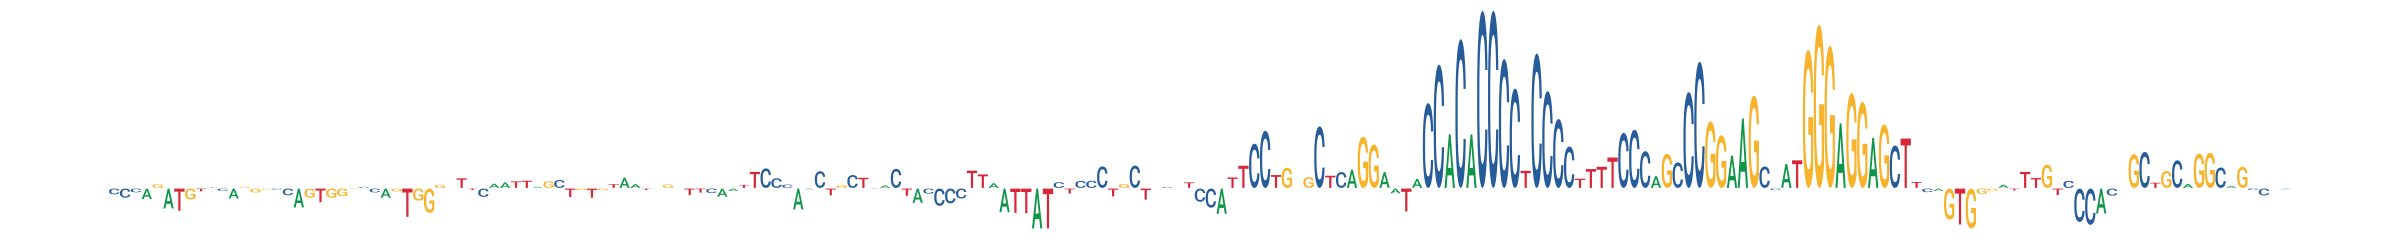

In [209]:
options(repr.plot.width = 20, repr.plot.height = 2)

plot_seq(t(imp_h5dats[[1]][,,99252]), lower_lims[[1]], upper_lims[[1]], clip=T, cutrange = 1000:1200) 

In [240]:
options(repr.plot.width = 5, repr.plot.height = 24)
cluster_config_selected = cluster_config[as.character(CLUSTERS),]
cluster_config_selected$y = factor(paste(cluster_config_selected$new_cluster, cluster_config_selected$description, sep=' - '))
levels(cluster_config_selected$y) = cluster_config_selected$y[rev(order(cluster_config_selected$new_cluster))]

cluster_colourbar <- ggplot(cluster_config_selected, 
                            aes(x=1, 
                            y=y, 
                            fill = y, 
                            label= y)) +
  geom_bar(stat="identity") +
#   ylab("scRNA Cell State") +
  theme_void() +
  scale_fill_manual(values = as.character(cluster_config_selected$colour[rev(order(cluster_config_selected$new_cluster))])) +
  theme(legend.position = 'none',
        axis.text.y = element_text(size=26, margin=margin(t= 10)),
#         axis.title.y = element_text(size=20, angle=90, margin=margin(t=10))
       ) # adjust this to match heights

In [447]:
CL = 1
RG = "chr19:44905425-44906171"
as.character(imp_regions[[CL]][queryHits(findOverlaps(imp_regions[[CL]], GRanges(RG)))])

[1] "chr19:44905608-44907608"

In [368]:
as.character(imp_regions[[16]][queryHits(findOverlaps(imp_regions[[16]], GRanges("chr12:7717924-7719113")))])

character(0)

In [448]:
# for unclear reasons this doesn't work inside a function
# returns missing variable seqidx

REG = "chr19:44905608-44907608"
CUTRG = NULL #1100:1300
CLP = T

imp_scores_plots = c()

for (i in CLUSTERS) {

    if (any(imp_regions[[i]]==REG)) {
#             print(region)
#             print(i)
#             print(which(imp_regions[[i]]==region))
        seqidx = which(imp_regions[[i]]==REG)
#             print(seqidx)
        m = t(imp_h5dats[[i]][,,seqidx])

        imp_scores_plots[[i]] = plot_seq(m,
                                    lower_lims[[i]], 
                                    upper_lims[[i]],
                                    clip=CLP, 
                                    cutrange=CUTRG)
    }

    else {
        imp_scores_plots[[i]] = plot_spacer()
    }
}

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which wi

In [449]:
W = 200
H = 24
options(repr.plot.width = W, repr.plot.height = H)

p = wrap_plots(cluster_colourbar,
           wrap_plots(imp_scores_plots[CLUSTERS[order(cluster_config[as.character(CLUSTERS), "new_cluster"])]],
                      ncol=1),
           widths = c(1,W-1))
p

In [443]:
ggsave("./tmp.png", p, width=25, height=20)

---

In [ ]:
sessionInfo()